In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
torch.cuda.empty_cache()
#data_flag = 'pathmnist'
#data_flag = 'breastmnist'
#data_flag = 'bloodmnist'
#data_flag = 'tissuemnist'
#data_flag = 'organamnist'
#data_flag = 'organcmnist'
#data_flag = 'organsmnist'
#data_flag = 'dermamnist'
#data_flag = 'retinamnist'
#data_flag = 'pneumoniamnist'
#data_flag = 'chestmnist'
data_flag = 'octmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 16
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# preprocessing
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])


#Densenet and res2net
if n_channels==3:
    data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
else: 
    data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

#R2Unet
# data_transform = transforms.Compose([
#     transforms.Resize(128),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])




# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
testloader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Jan Super\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Jan Super\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Jan Super\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Jan Super\.medmnist\octmnist.npz


In [4]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

In [5]:
from res2net import res2net50
from r2unet import U_Net, R2U_Net
#model = res2net50(pretrained=False, num_classes=n_classes)
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False, num_classes=n_classes)
#model = R2U_Net(img_ch=3, output_ch=n_classes)
#model = U_Net(img_ch=n_channels, output_ch=n_classes)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Using cache found in C:\Users\Jan Super/.cache\torch\hub\pytorch_vision_v0.10.0
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
def testVal(split):
    model.eval()
    y_true = torch.tensor([])
    #y_true = y_true.to(device)
    y_score = torch.tensor([])
    #y_score = y_score.to(device)
    l = 0
    
    data_loader = train_loader_at_eval if split == 'train' else val_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            if (n_channels == 1):
                inputs = torch.cat((torch.cat((inputs,inputs), 1),inputs),1)
                inputs = inputs.to(device)
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            
            outputs = model(inputs)
            
            # print("------------")
            # print(outputs.shape)
            # print(targets.shape)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)
                
            # print(outputs.shape)
            # print(targets.shape)
            
            outputs = outputs.to(torch.device('cpu'))
            targets = targets.to(torch.device('cpu'))
            
            # print(outputs.shape)
            # print(targets.shape)
            # print("------------")
            

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            
            #print(y_score)
           

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        # print(y_true.shape)
        # print(y_score.shape)
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
        # train_acc = torch.sum(y_score == y_true)

In [7]:
model = model.to(device)
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        if (n_channels == 1):
            inputs = torch.cat((torch.cat((inputs,inputs), 1),inputs),1) 
        inputs = inputs.to(device)
        targets = targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
    # print('==> Evaluating ...')
    # testVal('train')
    # testVal('val')

100%|██████████| 6093/6093 [11:40<00:00,  8.69it/s]


In [8]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    #y_true = y_true.to(device)
    y_score = torch.tensor([])
    #y_score = y_score.to(device)
    l = 0
    
    data_loader = train_loader_at_eval if split == 'train' else testloader

    with torch.no_grad():
        for inputs, targets in data_loader:
            if (n_channels == 1):
                inputs = torch.cat((torch.cat((inputs,inputs), 1),inputs),1)
                inputs = inputs.to(device)
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            
            outputs = model(inputs)
            
            # print("------------")
            # print(outputs.shape)
            # print(targets.shape)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)
                
            # print(outputs.shape)
            # print(targets.shape)
            
            outputs = outputs.to(torch.device('cpu'))
            targets = targets.to(torch.device('cpu'))
            
            # print(outputs.shape)
            # print(targets.shape)
            # print("------------")
            

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            
            #print(y_score)
           

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        # print(y_true.shape)
        # print(y_score.shape)
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
        # train_acc = torch.sum(y_score == y_true)

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.992  acc:0.951
test  auc: 0.963  acc:0.785


1
Approximation delta:  tensor([0.1309], dtype=torch.float64)
2
3
Original Image


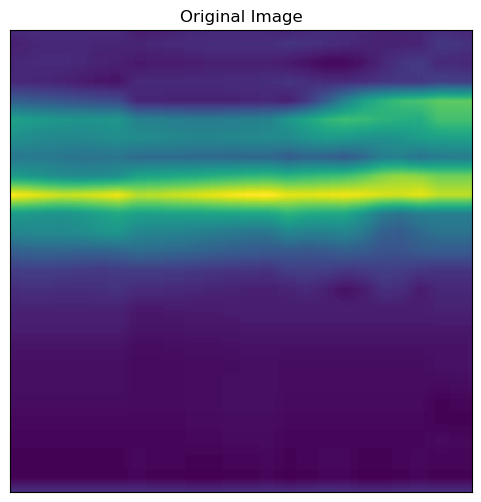

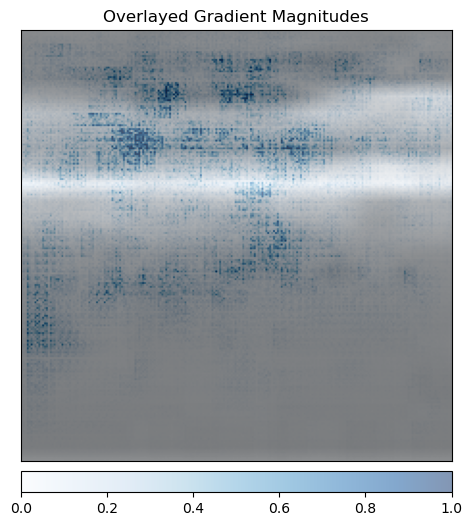

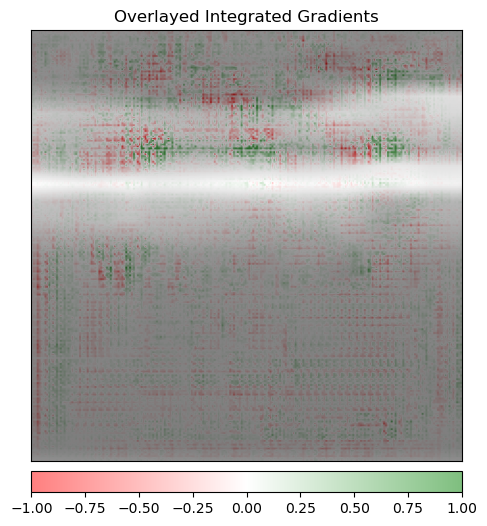

In [9]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=test_dataset[ind][1].item(),
                                              **kwargs
                                             )
    
    return tensor_attributions
        
model = model.to('cpu')
model = model.eval()
net = model

ind = 3

input = test_dataset[ind][0].unsqueeze(0)
input = torch.cat((torch.cat((input,input), 1),input),1)
input.requires_grad = True
print("1")
saliency = Saliency(net)
grads = saliency.attribute(input, test_dataset[ind][1].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))
print("2")
# ig = IntegratedGradients(net)
# nt = NoiseTunnel(ig)
# attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
#                                       nt_samples=100, stdevs=0.2)
# attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
print("3")
# dl = DeepLift(net)
# attr_dl = attribute_image_features(dl, input, baselines=input * 0)
# attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
print('Original Image')
# print('Predicted:', classes[predicted[ind]], 
#       ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((test_dataset[ind][0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

# _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
#                              outlier_perc=10, show_colorbar=True, 
#                              title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

# _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
#                           title="Overlayed DeepLift")